# Improving WW3 predction with Machine Learning

First, install the requirements:

```bash
# create a new environment
conda create --name tf python=3.7
# activate your new environment
conda activate tf

# install tensorflow CPU version
conda install tensorflow=2
conda install tensorboard

# If you have a NVIDIA GPU installed and properly configured
conda install tensorflow-gpu=2
conda install tensorboard

# Natsort - better file sorting
conda install natsort

# Data I/O
import xarray as xr

# Classical machine learning
conda install pandas scikit-learn scikit-image

# Matplotlib and seaborn
conda install matplotlib seaborn

# plot your models
conda install pydot graphviz

# make your life easier with ipython
conda install ipython
```


## 1 - Improving wave direction using integrated wave parameters (Hs, Tp, Dp, Sp)

In this first example, the model is trained with integrated parameters extracted from WW3.

The target is the measured wave direction.

## 1.1 - Import the packages

In [1]:
import os

import pandas as pd

import numpy as np

import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from joblib import dump

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1.25, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {"axes.linewidth": 2,
                        "legend.frameon": True,
                        "axes.facecolor": "#E9E9F1",
                        "grid.color": "w"})
mpl.rcParams["axes.linewidth"] = 2

## 1.2 - Define hyperparameters for the model

In [2]:
# Hyperparameters
TEST_SIZE = 0.3  # Fraction of data to use as test
RANDOM_STATE = 42  # State for reproducibility
MODEL = "MLP"  # Model name
STRATIFY = True  # make sure to use balanced dataset
LEARNING_RATE = 0.0001
EPOCHS = 1024  # Number of epochs to train the model
LAYERS = 2  # Number hidden layers
NEURONS = 512 # Number of Neurons per layer
DROPOUT = 0.25  # Dropout rate between layers

# remove previous trained model, if any
# this model is fast to train, so no need to
# re-train from a previous run
if os.path.isfile("{}.h5".format(MODEL)):
    os.remove("{}.h5".format(MODEL))
if os.path.isfile("{}_xscaler.dat".format(MODEL)):
    os.remove("{}_xscaler.dat".format(MODEL))

## 1.3 - Load data

In [3]:
# load the daaset
DATA = "integrated_parameters.csv"  # Input data
df = pd.read_csv(DATA, delimiter=",")
print(df.keys())

Index(['Time_UTC', 'Hm0_mod', 'Te_mod', 'Tm1_mod', 'Tm2_mod', 'Tp_mod',
       'Dm_mod', 'Spr_mod', 'uwind_mod', 'vwind_mod', 'Hm0_obs', 'Te_obs',
       'Dm_obs', 'Lat', 'Lon', 'depth', 'ID'],
      dtype='object')


In [4]:
print(df.describe())

            Hm0_mod        Te_mod       Tm1_mod       Tm2_mod        Tp_mod  \
count  51826.000000  51826.000000  51826.000000  51826.000000  51826.000000   
mean       2.103466     11.406632      9.695720      8.520542     14.194782   
std        0.634239      1.722541      1.724572      1.657223      2.514070   
min        0.697049      7.029079      5.319321      4.428405      5.834560   
25%        1.638022     10.163786      8.442286      7.315931     12.506901   
50%        2.003050     11.276141      9.491600      8.288149     13.757591   
75%        2.450112     12.594807     10.832838      9.514371     15.133350   
max        6.269242     19.772448     16.758249     15.760787     26.809652   

             Dm_mod       Spr_mod     uwind_mod     vwind_mod       Hm0_obs  \
count  51826.000000  51826.000000  51826.000000  51826.000000  51826.000000   
mean     240.942778     78.529360     -2.924790     -0.671898      1.831240   
std       18.182411      0.156940      3.782149    

In [5]:
print("These are the different locations:")
print(df["ID"].unique())

These are the different locations:
['ACardo' 'AConst' 'ACurau' 'ALavap' 'ALCNorte' 'ALCSur' 'ALebu' 'ALobos'
 'ALoros' 'AMorgu' 'ATopoc' 'BCurau' 'BLebu']


## 1.4 - Prepare the training, testing and validation datasets

In [6]:
# Define the varibles we are going to use to train the model
train_features = ["Hm0_mod", "Tm1_mod", "Tm2_mod", "Spr_mod", "uwind_mod", "vwind_mod", "Dm_mod_sinx", "Dm_mod_cosx"]

In [7]:
# covert Dm_obs and Dm_mod to radians so that it is a continous
# variable between -pi and pi

df["Dm_mod_rad"] = np.deg2rad(df["Dm_mod"]) - np.pi
df["Dm_obs_rad"] = np.deg2rad(df["Dm_obs"]) - np.pi

# Compute the sin and cos of the direction.
# These are the target variables
# using the raw direction will cause the model not to learn
# anything beucause of the modular nature of directions.

df["Dm_mod_sinx"] = np.sin(df["Dm_mod_rad"])
df["Dm_mod_cosx"] = np.cos(df["Dm_mod_rad"])

df["Dm_obs_sinx"] = np.sin(df["Dm_obs_rad"])
df["Dm_obs_cosx"] = np.cos(df["Dm_obs_rad"])

In [8]:
# prepare input array - Model data
X = df[train_features].values

# prepare output array - Buoy data
y = df[["Dm_obs_sinx", "Dm_obs_cosx"]].values

# convert ID to int in order to preserve class PDF
# when doing the train/test split
if STRATIFY:
    df["labels"] = pd.factorize(df["ID"])[0].astype(np.uint16)
    labels = df["labels"].values
else:
    labels = np.ones(y.shape)

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE,
    shuffle=None)

# split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, shuffle=True)

In [9]:
print("There are {} training samples, {} validation samples, and {} testing samples".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

There are 25394 training samples, 10884 validation samples, and 15548 testing samples


In [10]:
# scale the input X data in the 0-1 range
xscaler = MinMaxScaler().fit(X_train)
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.fit_transform(X_test)
X_val = xscaler.fit_transform(X_val)

# save the scaler for later usage
dump(xscaler, "{}_xscaler.dat".format(MODEL))

['MLP_xscaler.dat']

In [11]:
print(X_train.shape)

(25394, 8)


## 1.5 - Model definition

In [12]:
# build the model
nlayers = int(LAYERS)
neurons = int(NEURONS)
drop_rate = float(DROPOUT)

layers = []

# add the input layer
layers.append(Dense(neurons, activation="relu",
              kernel_initializer="glorot_normal",
              input_shape=[X_train.shape[1]]))
layers.append(Dropout(drop_rate))

# add the other layers
for l in range(nlayers-1):
    layers.append(Dense(neurons, activation="relu"))
    layers.append(Dropout(drop_rate))

# add the output layer
layers.append(Dense(2, activation="tanh"))

# build the model
model = Sequential(layers)

optimizer = Adam(learning_rate=float(LEARNING_RATE))
model.compile(optimizer=optimizer,
              loss="mse",
              metrics=["mse"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 268,290
Trainable params: 268,290
Non-trainable params: 0
_________________________________________________________________


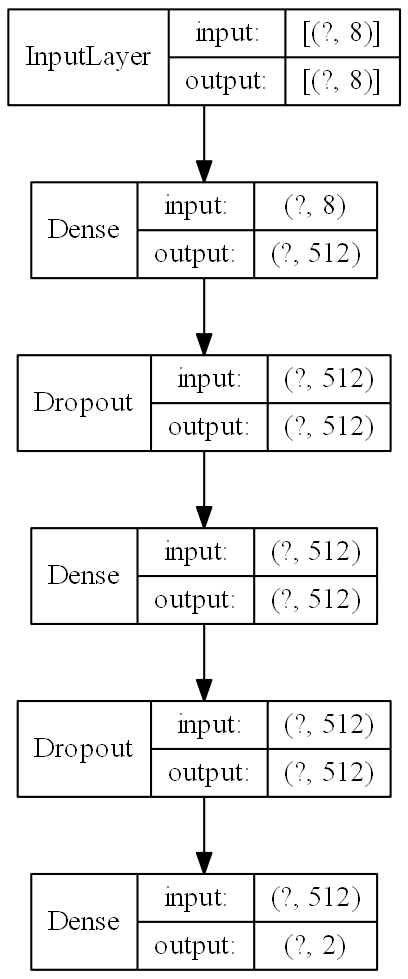

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='arc_mlp_wavepar.png', show_shapes=True, rankdir='TD', expand_nested=False, dpi=150, show_layer_names=False)


## 1.6 - Train the model

In [13]:
history = model.fit(X_train, y_train,
                    batch_size=len(X_train),
                    epochs=int(EPOCHS),
                    verbose=1,
                    validation_data=(X_val, y_val))
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Train on 25394 samples, validate on 10884 samples
Epoch 1/1024
25394/25394 [==============================] - 2s 75us/sample - loss: 0.5410 - mean_squared_error: 0.5410 - val_loss: 0.5091 - val_mean_squared_error: 0.5091
Epoch 2/1024
25394/25394 [==============================] - 1s 43us/sample - loss: 0.5126 - mean_squared_error: 0.5126 - val_loss: 0.4815 - val_mean_squared_error: 0.4815
Epoch 3/1024
25394/25394 [==============================] - 1s 27us/sample - loss: 0.4847 - mean_squared_error: 0.4847 - val_loss: 0.4549 - val_mean_squared_error: 0.4549
Epoch 4/1024
25394/25394 [==============================] - 1s 29us/sample - loss: 0.4575 - mean_squared_error: 0.4575 - val_loss: 0.4294 - val_mean_squared_error: 0.4294
Epoch 5/1024
25394/25394 [==============================] - 1s 28us/sample - loss: 0.4312 - mean_squared_error: 0.4312 - val_loss: 0.4049 - val_mean_squared_error: 0.4049
Epoch 6/1024
25394/25394 [==============================] - 1s 24us/sample - loss: 0.4068 - mea

Epoch 49/1024
25394/25394 [==============================] - 1s 24us/sample - loss: 0.0545 - mean_squared_error: 0.0545 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 50/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 51/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 52/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 53/1024
25394/25394 [==============================] - 1s 23us/sample - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 54/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0446 -

Epoch 97/1024
25394/25394 [==============================] - 1s 27us/sample - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 98/1024
25394/25394 [==============================] - 1s 28us/sample - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 99/1024
25394/25394 [==============================] - 1s 27us/sample - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 100/1024
25394/25394 [==============================] - 1s 27us/sample - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 101/1024
25394/25394 [==============================] - 1s 26us/sample - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 102/1024
25394/25394 [==============================] - 1s 27us/sample - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.030

Epoch 145/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 146/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 147/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 148/1024
25394/25394 [==============================] - 1s 23us/sample - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 149/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 150/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.

Epoch 193/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 194/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 195/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 196/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 197/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 198/1024
25394/25394 [==============================] - 0s 17us/sample - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.

Epoch 241/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 242/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 243/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 244/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 245/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 246/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.

Epoch 289/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 290/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 291/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 292/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 293/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 294/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.

Epoch 337/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 338/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 339/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 340/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 341/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 342/1024
25394/25394 [==============================] - 1s 24us/sample - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.

Epoch 385/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 386/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 387/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 388/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 389/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 390/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.

Epoch 433/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 434/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 435/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 436/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 437/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 438/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.

Epoch 481/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 482/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 483/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 484/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 485/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 486/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.

Epoch 529/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 530/1024
25394/25394 [==============================] - 0s 17us/sample - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 531/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 532/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 533/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 534/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.

Epoch 577/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 578/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 579/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 580/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 581/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 582/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.

Epoch 625/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 626/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 627/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 628/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 629/1024
25394/25394 [==============================] - 0s 17us/sample - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 630/1024
25394/25394 [==============================] - 0s 20us/sample - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.

Epoch 673/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 674/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 675/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 676/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 677/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 678/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.

Epoch 721/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 722/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 723/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 724/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 725/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 726/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.

Epoch 769/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 770/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 771/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 772/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 773/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 774/1024
25394/25394 [==============================] - 1s 22us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.

Epoch 817/1024
25394/25394 [==============================] - 0s 17us/sample - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 818/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 819/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 820/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 821/1024
25394/25394 [==============================] - 0s 17us/sample - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 822/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.

Epoch 865/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 866/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 867/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 868/1024
25394/25394 [==============================] - 1s 20us/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 869/1024
25394/25394 [==============================] - 1s 21us/sample - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 870/1024
25394/25394 [==============================] - 1s 24us/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.

Epoch 913/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 914/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 915/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 916/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 917/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 918/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.

Epoch 961/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 962/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 963/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 964/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 965/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 966/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.

Epoch 1009/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 1010/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 1011/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 1012/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 1013/1024
25394/25394 [==============================] - 0s 19us/sample - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 1014/1024
25394/25394 [==============================] - 0s 18us/sample - loss: 0.0198 - mean_squared_error: 0.0198 - val_lo

In [14]:
# save model to file
print("\n - Saving model to file")
model.save("{}.h5".format(MODEL))
hist.to_csv("{}_history.csv".format(MODEL))
print("model saved!")


 - Saving model to file
model saved!


In [15]:
# predict on the test set and convert back to radians
y_pred = np.squeeze(model.predict(X_test))
y_pred_rescaled = np.arctan2(y_pred[:, 0], y_pred[:, 1])
y_test_rescaled = np.arctan2(y_test[:, 0], y_test[:, 1])

## 1.7 -  Results

In [16]:
print("\n - Results (in radians)")
print("\n   WW3")
ww3_r2 = r2_score(df["Dm_mod_rad"].values,
                  df["Dm_obs_rad"].values)
print("     r2-score:", round(ww3_r2, 2))
ww3_rmse = np.sqrt(mean_squared_error(df["Dm_mod_rad"].values,
                                      df["Dm_obs_rad"].values))
print("     rmse:", round(ww3_rmse, 2))
ww3_mae = mean_absolute_error(df["Dm_mod_rad"].values,
                              df["Dm_obs_rad"].values)
print("     mae", round(ww3_mae, 2))

print("\n   MLP")
mlp_r2 = r2_score(y_pred_rescaled, y_test_rescaled)
print("     r2-score:", round(mlp_r2, 2))
mlp_rmse = np.sqrt(mean_squared_error(y_pred_rescaled,
                                      y_test_rescaled))
print("     rmse:", round(mlp_rmse, 2))
mlp_mae = mean_absolute_error(y_pred_rescaled, y_test_rescaled)
print("     mae", round(mlp_mae, 2))


 - Results (in radians)

   WW3
     r2-score: 0.07
     rmse: 0.31
     mae 0.24

   MLP
     r2-score: 0.67
     rmse: 0.19
     mae 0.15


## 1.8 - Plots

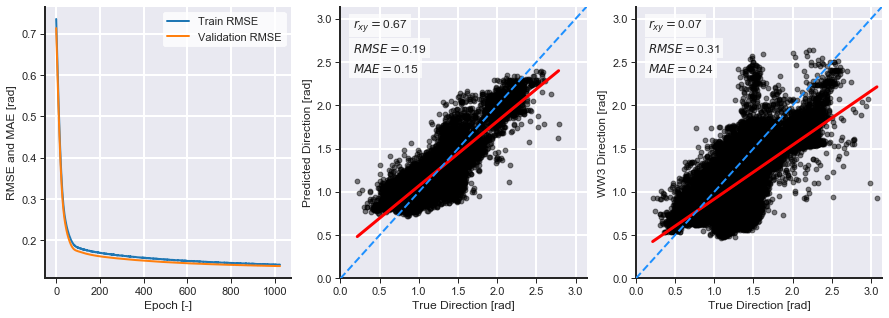

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(hist["epoch"], np.sqrt(hist["mean_squared_error"]), label="Train RMSE")
ax1.plot(hist["epoch"], np.sqrt(hist["val_mean_squared_error"]), label="Validation RMSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RMSE [rad]")

lg = ax1.legend()
lg.get_frame().set_color("w")

ax1.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax1)

ax1.set_ylabel("RMSE and MAE [rad]")
ax1.set_xlabel("Epoch [-]")

sns.regplot(y_test_rescaled, y_pred_rescaled, ax=ax2, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax2.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax2.set_xlabel("True Direction [rad]")
ax2.set_ylabel("Predicted Direction [rad]")

ax2.set_xlim(0, 3.14)
ax2.set_ylim(0, 3.14)

ax2.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax2)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(mlp_r2)
ax2.text(0.05, 0.9, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(mlp_rmse)
ax2.text(0.05, 0.825, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(mlp_mae)
ax2.text(0.05, 0.75, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

# plot WW3 results
y_ww3_rescaled = np.arctan2(df["Dm_mod_sinx"].values,
                            df["Dm_mod_cosx"].values)
y_obs_rescaled = np.arctan2(df["Dm_obs_sinx"].values,
                            df["Dm_obs_cosx"].values)
sns.regplot(y_obs_rescaled, y_ww3_rescaled, ax=ax3, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax3.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax3.set_xlim(0, 3.14)
ax3.set_ylim(0, 3.14)

ax3.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax3)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(ww3_r2)
ax3.text(0.05, 0.9, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(ww3_rmse)
ax3.text(0.05, 0.825, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(ww3_mae)
ax3.text(0.05, 0.75, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

ax3.set_xlabel("True Direction [rad]")
ax3.set_ylabel("WW3 Direction [rad]")
plt.show()

In [18]:
y_pred = np.squeeze(model.predict(xscaler.transform(X)))
y_pred_angles = np.rad2deg(np.arctan2(y_pred[:, 0], y_pred[:, 1]) + np.pi)
df["prediction"] = y_pred_angles
dfl = df.loc[df["ID"] == "ALebu"]

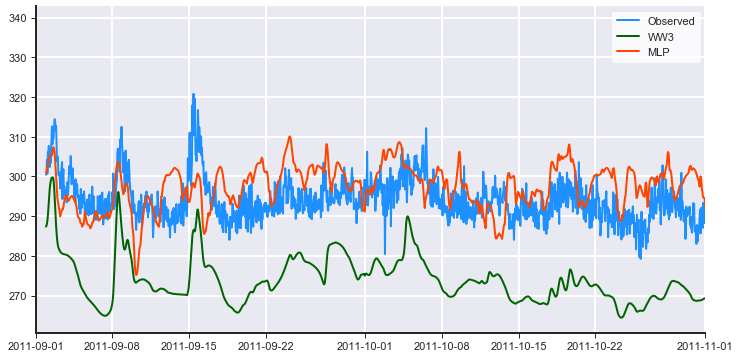

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

x = pd.to_datetime(dfl["Time_UTC"].values).to_pydatetime()
ytrue = dfl["Dm_obs"].values
ymod =  dfl["Dm_mod"].values
ymlp = dfl["prediction"].values

ax.plot(x, ytrue, color="dodgerblue", label="Observed")
ax.plot(x, ymod, color="darkgreen", label="WW3")
ax.plot(x, ymlp, color="orangered", label="MLP")

ax.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax)

lg = ax.legend(loc=1)
lg.get_frame().set_color("w")

ax.set_xlim(datetime.datetime(2011, 9, 1), datetime.datetime(2011, 11, 1))

plt.show()

## 1.9  - Save the results

In [20]:
df.to_csv("MLP_INT_PREDICTIONS.csv")

Not too bad but good but we can do much better!